# Learning how to create observables

For now this is just here to give us a place to play around with and demonstrate different observables. Eventually we can flesh it out into a full-blown observables tutorial.

We start from a simple toy data form a 2D nonlinear system. Then we build observables from `identity`, `polynomial`, `time delays`,`random fourier features` (isotropic gaussian kernel) with and without states included, and customized observables by manually defining lambda functions. Finally, we can even arbitrary concate those observables.

In [1]:
import sys
sys.path.append('../src')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

import pykoopman as pk

In [3]:
def data_2D_superposition():
    t = np.linspace(0, 2 * np.pi, 200)
    x = np.linspace(-5, 5, 100)
    [x_grid, t_grid] = np.meshgrid(x, t)

    def sech(x):
        return 1 / np.cosh(x)

    f1 = sech(x_grid + 3) * np.exp(1j * 2.3 * t_grid)
    f2 = 2 * (sech(x_grid) * np.tanh(x_grid)) * np.exp(1j * 2.8 * t_grid)
    return f1 + f2

x = data_2D_superposition()

In [4]:
def plot_observables(observables, x, t, input_features=None, t_delay=None):
    '''Generate plots of state variables before and after being transformed into new observables.'''
    n_features = x.shape[1]
    if input_features is None:
        input_features = [f'x{i}' for i in range(n_features)]
    if t_delay is None:
        t_delay = t
    
    # Plot input features (state variables)
    fig, axs = plt.subplots(1, n_features, figsize=(n_features * 5, 3))
    
    for ax, k, feat_name in zip(axs, range(n_features), input_features):
        ax.plot(t, x[:, k])
        ax.set(xlabel='t', title=feat_name)
    fig.suptitle('Original state variables')
    fig.tight_layout()
    # fig.show()
    
    # Plot output features
    y = observables.fit_transform(x)
    
    n_output_features = observables.n_output_features_
    feature_names = observables.get_feature_names(input_features)
    
    n_rows = (n_output_features // 3) + (n_output_features % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)
    
    for ax, k, feat_name in zip(axs.flatten(), range(n_output_features), feature_names):
        ax.plot(t_delay, y[:, k])
        ax.set(xlabel='t', title=feat_name)
    
    fig.suptitle('Observables')
    fig.tight_layout()
    # fig.show()
    return 

For our data we'll consider the simple nonlinear system with a single fixed point and a slow manifold:

$$\begin{aligned}\dot x_1 &= \mu x_1 \\ \dot x_2 &= \lambda\left( x_2 - x_1^2 \right) \end{aligned}$$

For $\lambda < \mu < 0$, the system has a slow attracting manifold along $x_2=x_1^2$ and a fixed point at $(0, 0)$.

In [5]:
mu = -1
lam = -10

def ode(z, t):
    return [
        mu * z[0],
        lam * (z[1] - z[0] ** 2)
    ]

dt = 0.01
t_train = np.arange(0, 10, dt)
x0_train = [3, 4]

x_train = odeint(ode, x0_train, t_train)

input_features = ["x1", "x2"]

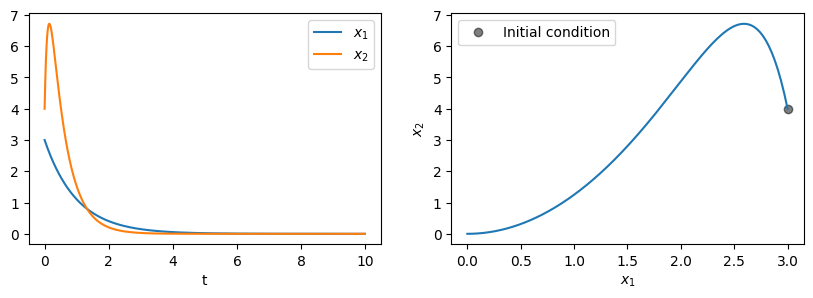

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(t_train, x_train[:, 0], label='$x_1$')
axs[0].plot(t_train, x_train[:, 1], label='$x_2$')
axs[0].set(xlabel='t')
axs[0].legend()

axs[1].plot(x_train[0, 0], x_train[0, 1], 'o', color='black', label="Initial condition", alpha=0.5)
axs[1].plot(x_train[:, 0], x_train[:, 1])
axs[1].set(xlabel='$x_1$', ylabel='$x_2$')
axs[1].legend();

## Identity
The `Identity` observables simply leave the state variables unmodified.

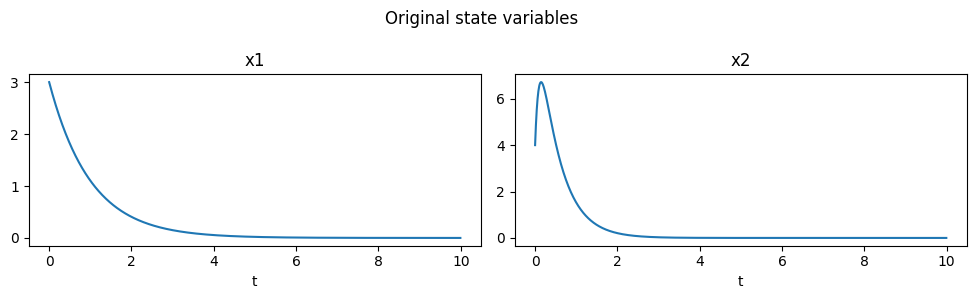

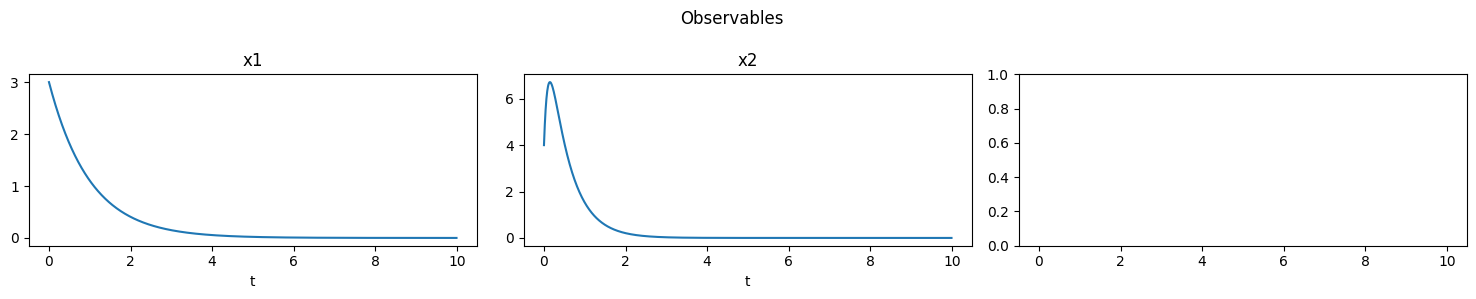

In [7]:
obs = pk.observables.Identity()
plot_observables(obs, x_train, t_train, input_features=input_features)

## Polynomial
`Polynomial` observables compute polynomial functions of the state variables.

D:\work\pykoopman\venv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
D:\work\pykoopman\venv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
D:\work\pykoopman\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


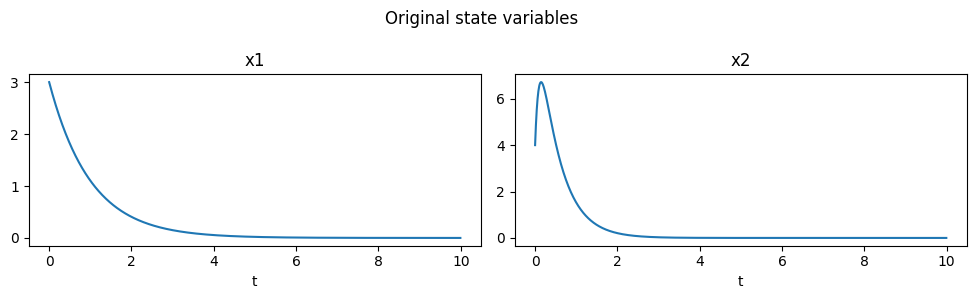

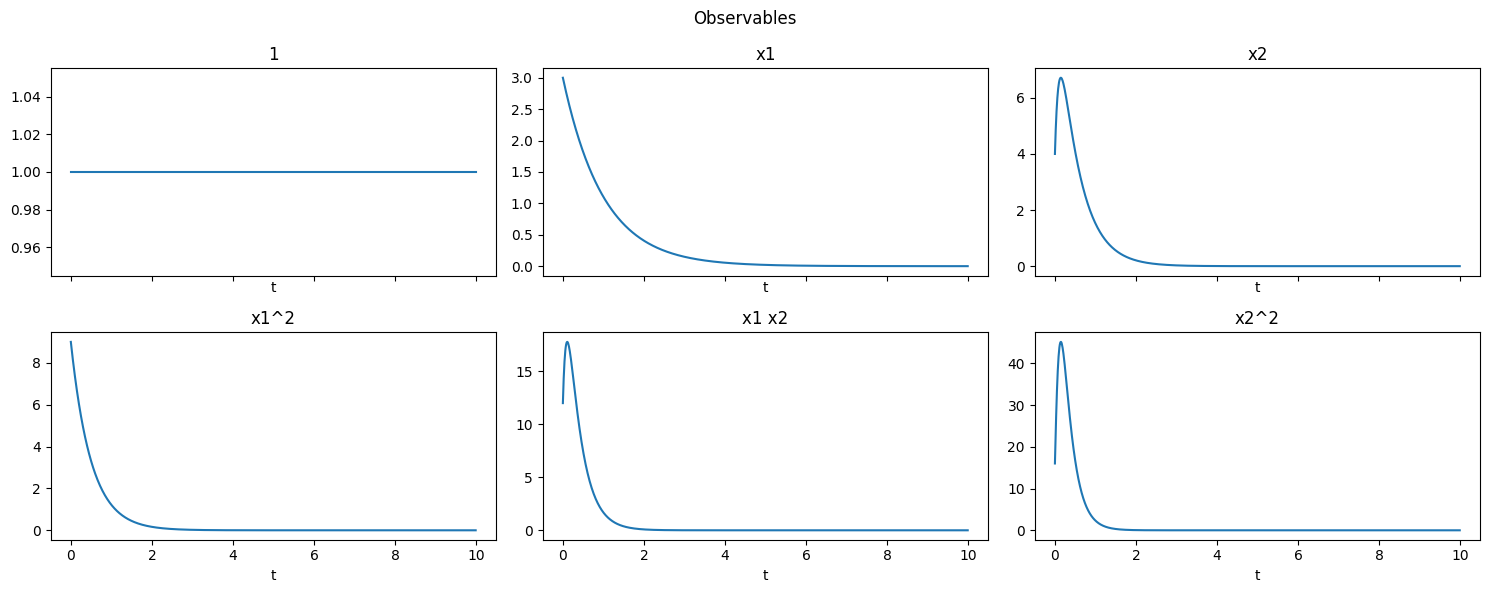

In [8]:
obs = pk.observables.Polynomial(degree=2)
plot_observables(obs, x_train, t_train, input_features=input_features)

## Time-delays
It is often useful to use time-delayed versions of state variables. For example, for
a case with `delay=1` and `n_delays=2`, it is the same as replacing $x(t)$ with $[x(t),
 x(t-\Delta t), x(t-2\Delta t)]$.

**Remark**
- For vector-valued system state, vectorized time delay is considered, in which the
order is given to every state at the latest time stamp, then all the states in
previous delayed time stamp, and so on.
- The `TimeDelay` class was designed to help construct such observables. Note that it
 "eats up" the first few state observations (rows of `x_train`) because these rows
 don't have enough time history to properly form delays. The information is not actually lost as it is used to form a delayed version of its corresponding state variable.

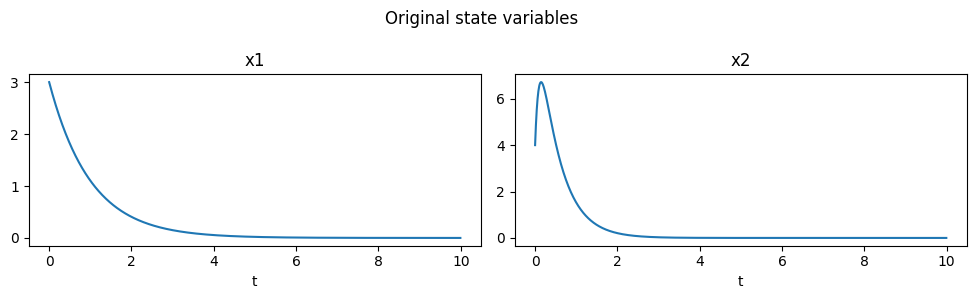

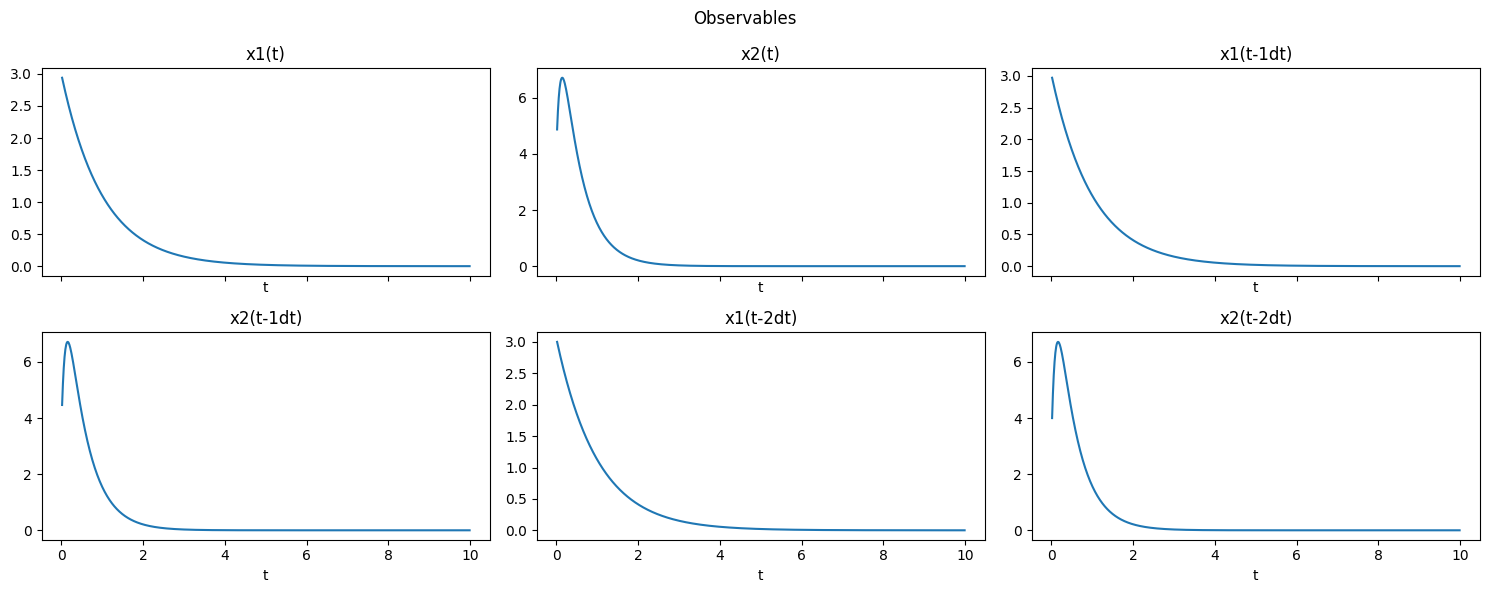

In [9]:
delay = 1 # dt
n_delays = 2
obs = pk.observables.TimeDelay(delay=delay, n_delays=n_delays)

t_delay = t_train[delay * n_delays:]
plot_observables(obs, x_train, t_train, input_features=input_features, t_delay=t_delay)

As expected, for such case we have in total 6 output features.

In [10]:
obs.n_output_features_

6

Certainly, one can play with larger stride such as `delay=5`.

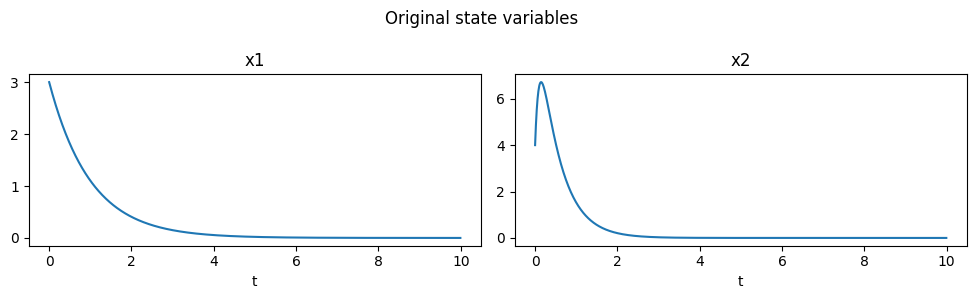

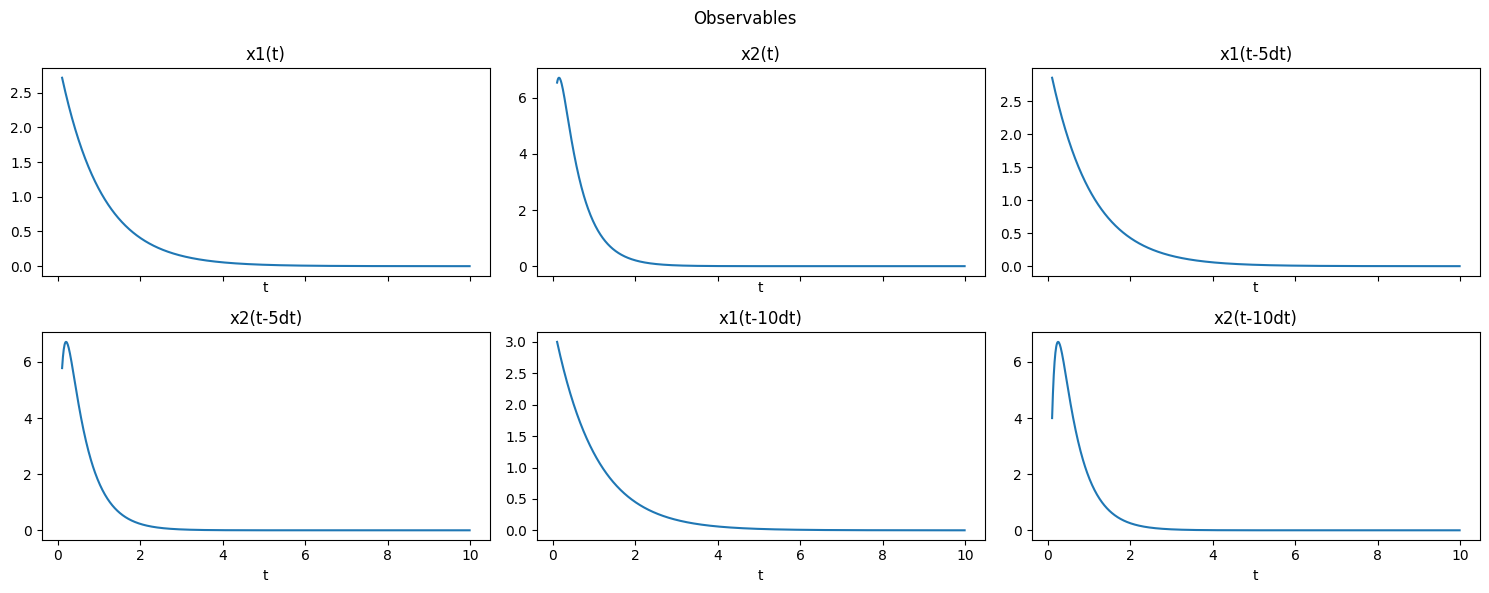

In [11]:
delay = 5 # dt
n_delays = 2 
obs = pk.observables.TimeDelay(delay=delay, n_delays=n_delays)

t_delay = t_train[delay * n_delays:]
plot_observables(obs, x_train, t_train, input_features=input_features, t_delay=t_delay)

In [12]:
obs.fit_transform(x_train).shape

(990, 6)

In [13]:
obs.get_feature_names()

['x0(t)', 'x1(t)', 'x0(t-5dt)', 'x1(t-5dt)', 'x0(t-10dt)', 'x1(t-10dt)']

## Random Fourier Features

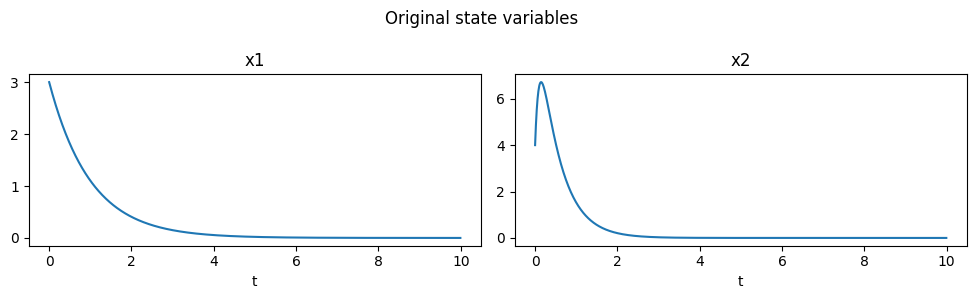

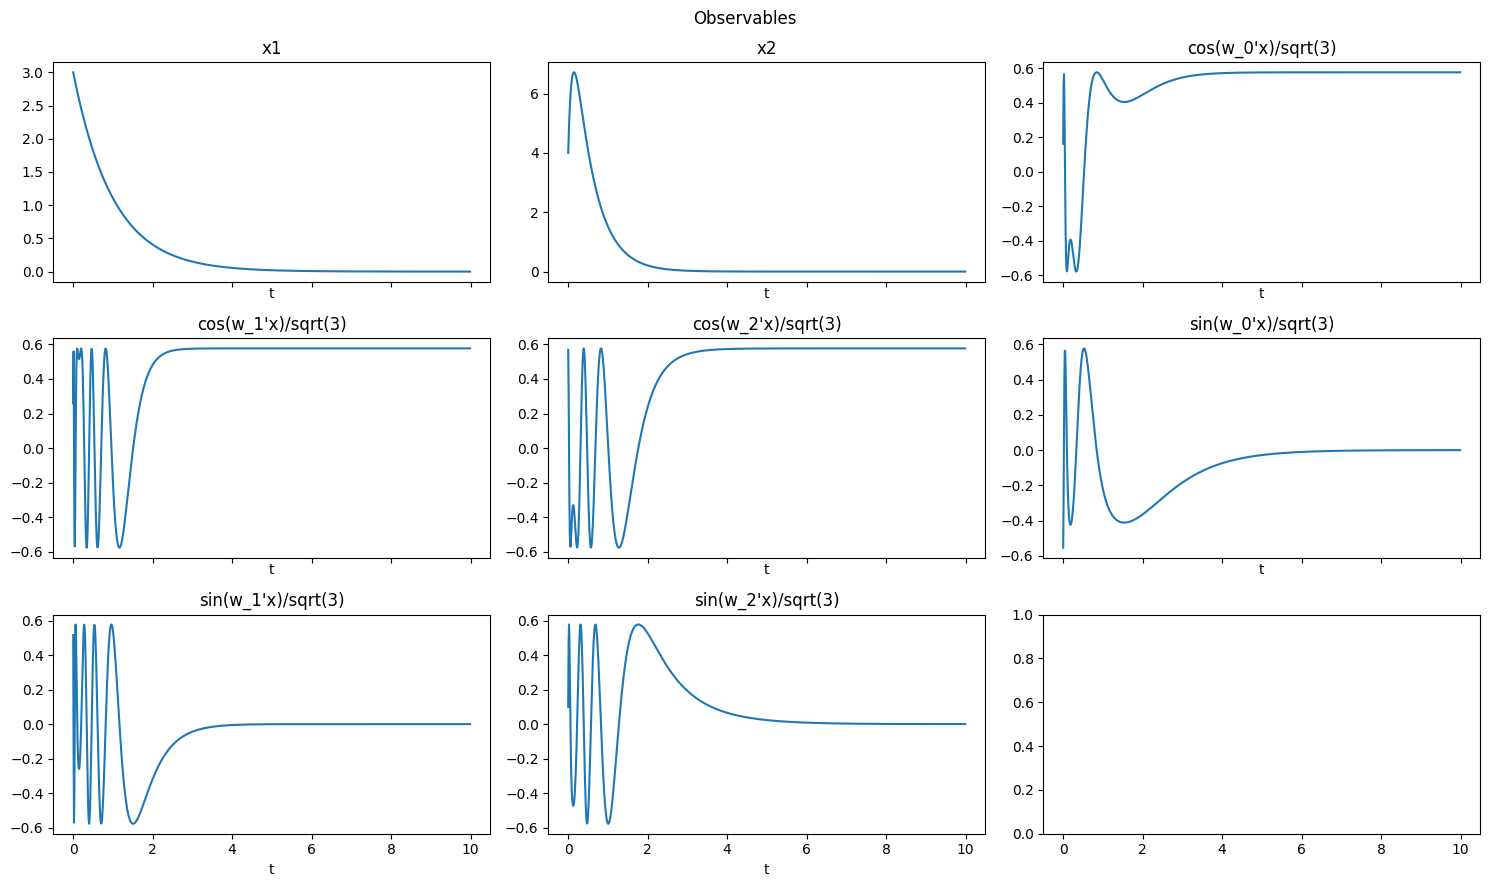

In [14]:
# with state
obs = pk.observables.RandomFourierFeatures(include_state=True,gamma=1.0,D=3)
plot_observables(obs, x_train, t_train, input_features=input_features)

D:\work\pykoopman\docs\../src\pykoopman\observables\_random_fourier_features.py:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.measurement_matrix_ = np.linalg.lstsq(z, x)[0].T


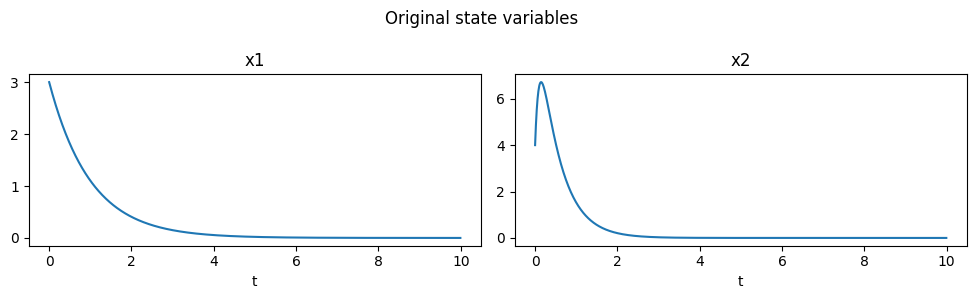

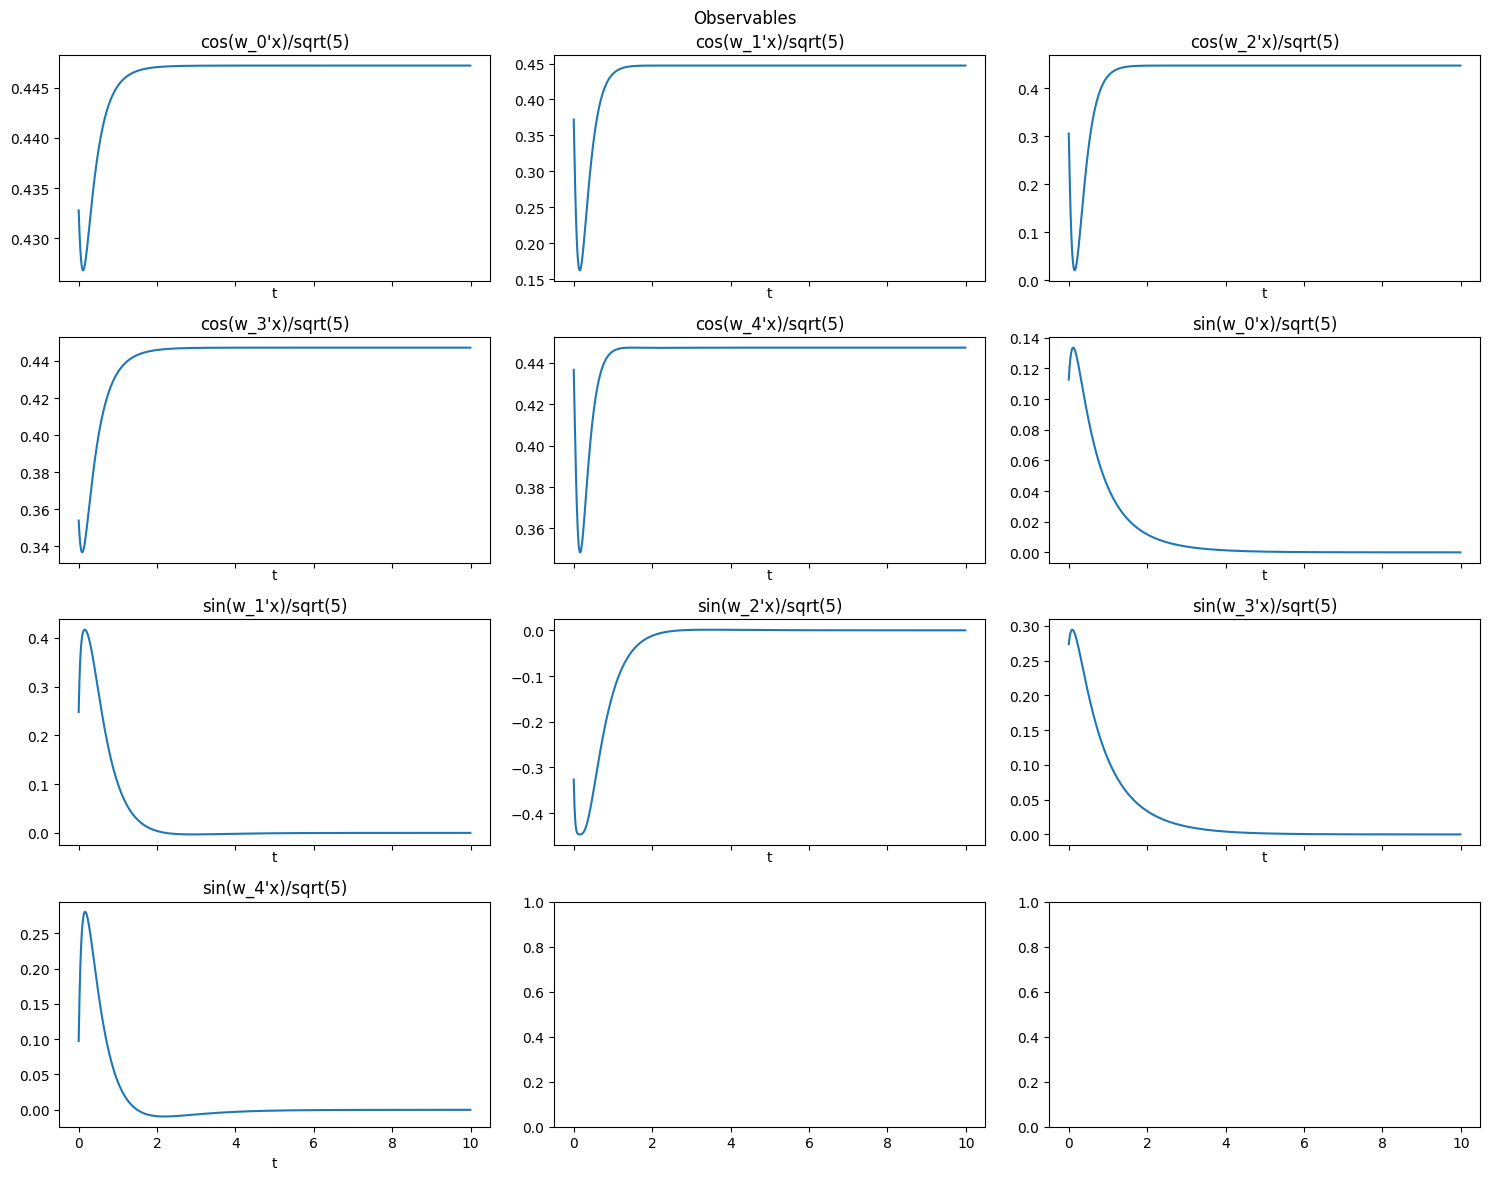

In [15]:
# without state
obs = pk.observables.RandomFourierFeatures(include_state=False,gamma=0.01,D=5)
plot_observables(obs, x_train, t_train, input_features=input_features)

## Custom observables
The `CustomObservables` class allows one to directly specify functions that should be applied to the state variables. Functions of one variable will be applied to each state variable and multivariable functions will be applied to every valid combination of variables.

Note: the original state variables are automatically included even when one omits the identity function from the set of specified functions.

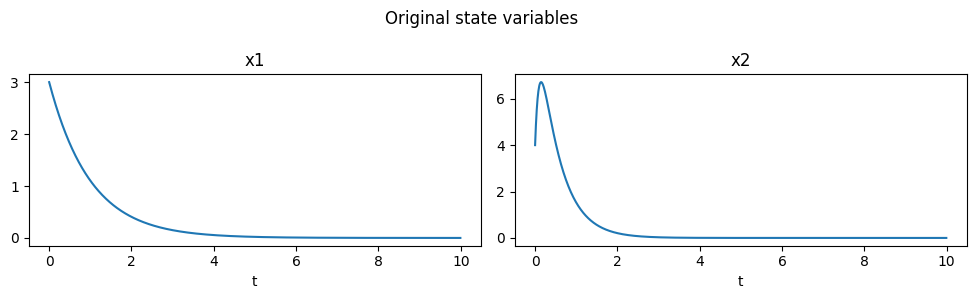

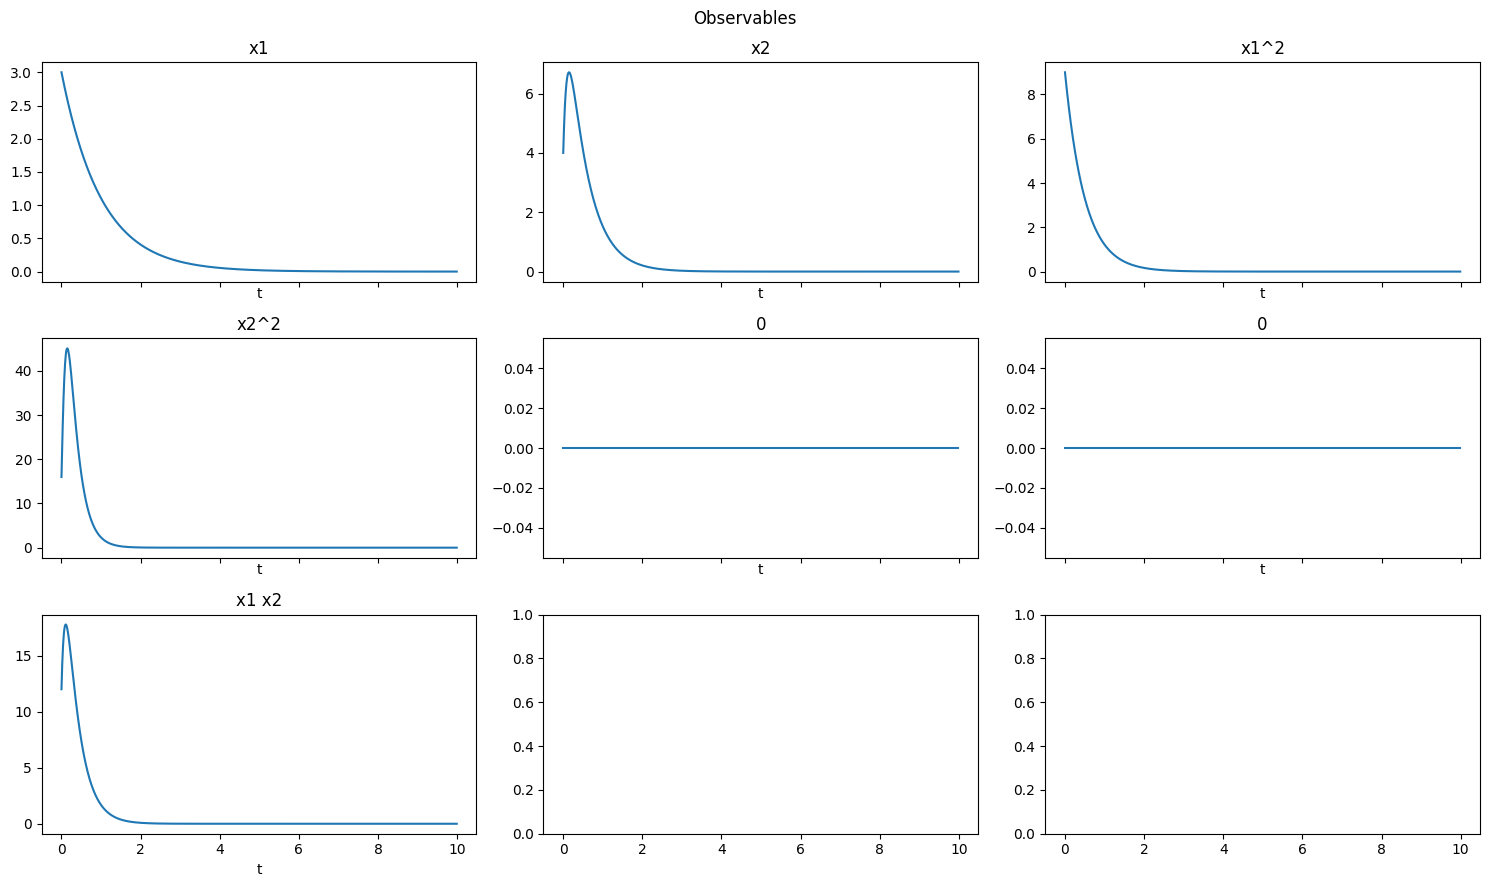

In [16]:
observables = [lambda x: x ** 2, lambda x: 0 * x, lambda x, y: x * y]
observable_names = [
    lambda s: f"{s}^2",
    lambda s: str(0),
    lambda s, t: f"{s} {t}",
]

obs = pk.observables.CustomObservables(observables, observable_names=observable_names)
plot_observables(obs, x_train, t_train, input_features=input_features)

## Concate observables

In [17]:
# first observable: from Polynomial combinations
ob1 = pk.observables.Polynomial(degree=1)

# second observable: from CustomObservables of univariate functions
observables = [lambda x: np.sin(x), lambda x: np.cos(x), lambda x, y: np.exp(x)*np.cos(y)]
observable_names = [
    lambda s: f"sin({s})",
    lambda s: f"cos({s})",
    lambda s, t: f"e^({s})cos({t})",
]
ob2 = pk.observables.CustomObservables(observables, observable_names=observable_names)

# third observable: a time delay observable
delay = 5 # dt
n_delays = 2 
t_delay = t_train[delay * n_delays:]
ob3 = pk.observables.TimeDelay(delay=delay, n_delays=n_delays)


# fourth observable: random fourier feature without state
ob4 = pk.observables.RandomFourierFeatures(include_state=False,gamma=0.01,D=2)

# fifth observable: random fourier feature with state
ob5 = pk.observables.RandomFourierFeatures(include_state=True,gamma=0.1,D=3)


obs = ob1 + ob2 + ob3 + ob4 + ob5




D:\work\pykoopman\docs\../src\pykoopman\observables\_random_fourier_features.py:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.measurement_matrix_ = np.linalg.lstsq(z, x)[0].T
D:\work\pykoopman\venv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
D:\work\pykoopman\venv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
D:\work\pykoopman\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is depr

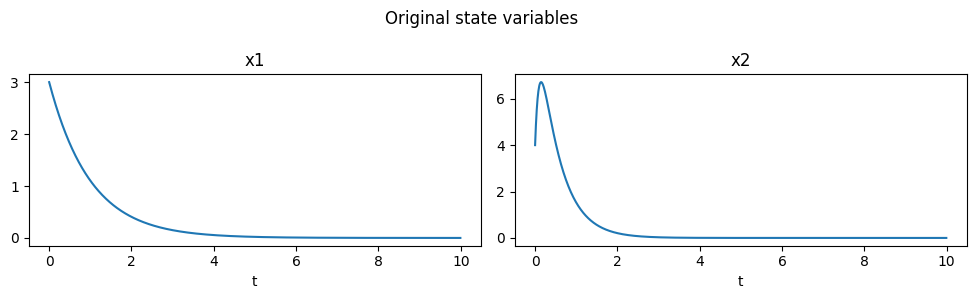

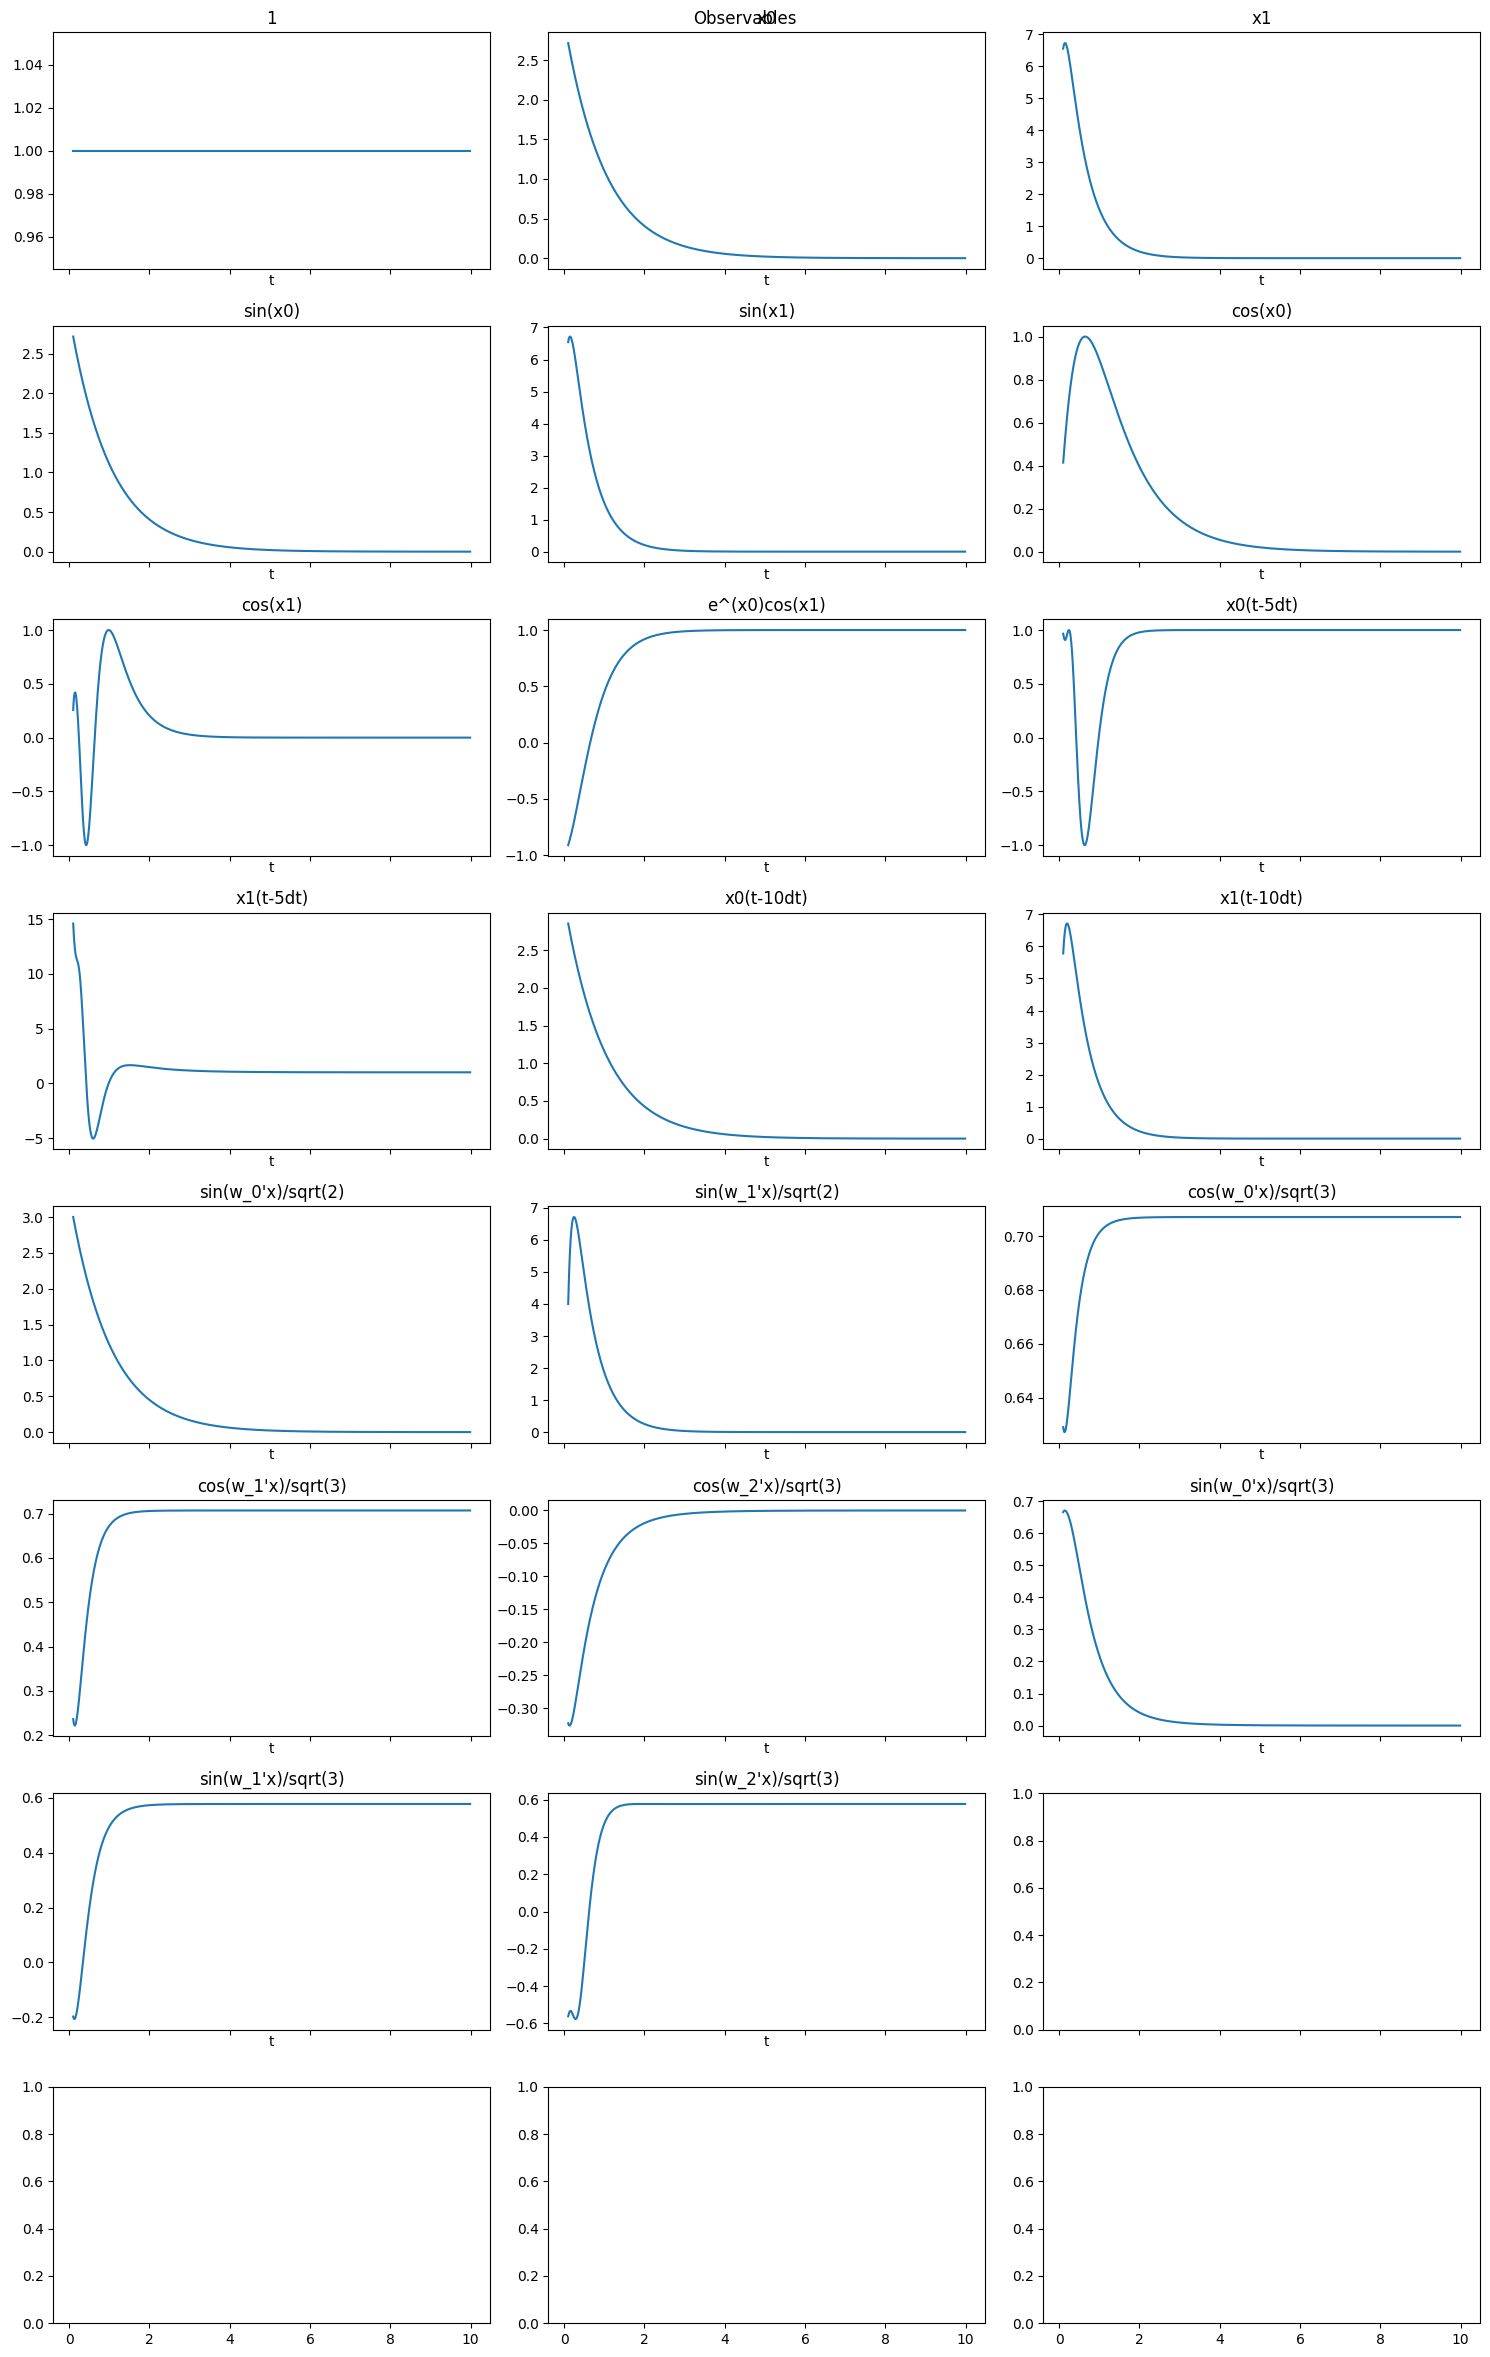

In [18]:

plot_observables(obs, x_train, t_train, input_features=input_features, t_delay=t_delay)

In [19]:
x_train.shape

(1000, 2)

In [20]:
obs.fit_transform(x_train).shape

D:\work\pykoopman\docs\../src\pykoopman\observables\_random_fourier_features.py:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.measurement_matrix_ = np.linalg.lstsq(z, x)[0].T
D:\work\pykoopman\venv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
D:\work\pykoopman\venv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


(990, 24)